In [1]:
import os

import numpy as np
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
import cv2

# tf imports
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras import backend as K

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPU


loading images with labels

In [3]:
f = open(".\data\measurements.json")
data_json = json.loads(f.read())["Measurements"]

vs = data_json.values()

df = pd.json_normalize(vs)

df.head()


,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
0,Lugano,RGB_27.png,Depth_27.png,5.5,0.42,9.0,11.0,153.9
1,Lugano,RGB_79.png,Depth_79.png,30.3,1.92,8.8,20.2,582.3
2,Lugano,RGB_140.png,Depth_140.png,60.9,2.83,11.6,19.0,960.6
3,Lugano,RGB_203.png,Depth_203.png,112.0,5.76,11.0,22.0,1614.9
4,Lugano,RGB_292.png,Depth_292.png,372.6,14.17,17.0,32.0,3839.6


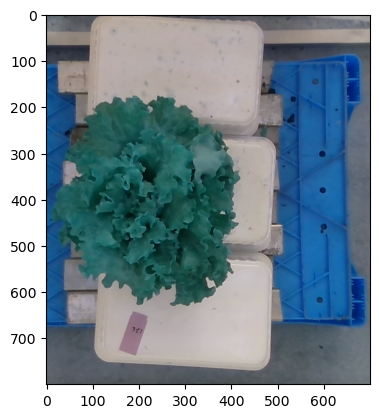

In [4]:
# testing images shaping
img = cv2.imread('.\data\RGBImagesResize\RGB_270.png')
w, h, c = img.shape

img = img[ (w // 2 - 400 ) : (w // 2 + 400) , (h // 2 - 400 + 100)  : (h // 2 + 400 + 100) ]
plt.imshow(img)

In [5]:
"""
    number: depth=0, RGB=1, depth/RGB=2
"""
def prepare_data(number=0, y_key='Height'):

    all_images = []
    y = []

    if number == 2:
        path_RGB = './data/RGBImagesResize/'
        key_RGB = 'RGB_Image'
        flag_RGB = cv2.IMREAD_COLOR

        path_depth = './data/DepthImagesResize/'
        key_depth = 'Depth_Information'
        flag_depth = cv2.IMREAD_GRAYSCALE


        for image_path_RGB in os.listdir(path_RGB):
            if df.loc[df[key_RGB] == image_path_RGB][y_key].size > 0:
                img_ID = image_path_RGB.strip(".png").strip("RGB_")
                y.append(df.loc[df[key_RGB] == image_path_RGB][y_key].item())
                img_RGB = cv2.imread(path_RGB + image_path_RGB, flag_RGB)
                img_RGB = cv2.resize(img_RGB, (250, 250))
                image_path_depth = path_depth + "Depth_"+ img_ID + ".png"
                img_depth = cv2.imread(image_path_depth, flag_depth)
                img_depth = cv2.resize(img_depth, (250,250))
                img_combined = np.dstack((img_RGB, img_depth))
                all_images.append(img_combined)
    else:
        if number == 1:
            path = './data/RGBImagesResize/'
            key = 'RGB_Image'
            flag = cv2.IMREAD_COLOR
        else:
            path = './data/DepthImagesResize/'
            key = 'Depth_Information'
            flag = cv2.IMREAD_GRAYSCALE

        for image_path in os.listdir(path):
            if df.loc[df[key] == image_path][y_key].size > 0:
                y.append(df.loc[df[key] == image_path][y_key].item())
                img = cv2.imread(path + image_path, flag)
                img = cv2.resize(img, (250, 250))
                all_images.append(img)


    X_train, X_test, y_train, y_test = train_test_split(np.array(all_images), y, test_size=0.25, shuffle=True)

    X_train = tf.convert_to_tensor(X_train)
    X_test = tf.convert_to_tensor(X_test)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)

    return X_train, y_train, X_test, y_test

ResNet Implementation for regression: depth images height

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

!!LET OP NIET RUNNEN ZONDER GPU!!

In [6]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [7]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [8]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [9]:
def create_res_net(input_shape, regression):
    inputs = Input(shape=input_shape)
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j == 0 and i != 0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(19, activation='softmax')(t)

    if regression:
        outputs = Dense(1, activation='linear')(t)

    model = Model(inputs, outputs)

    if regression:
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_percentage_error']
        )
    else:
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import datetime
import os

def fit_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    name = 'res_net'+timestr

    checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    os.system('mkdir {}'.format(checkpoint_dir))

    cp_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=0,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    tensorboard_callback = TensorBoard(
        log_dir=f'tensorboard_logs/{name}',
        histogram_freq=1
    )
    # early_stop_callback = EarlyStopping(
    #     monitor='val_loss',
    #     mode='min',
    #     patience=10
    # )

    model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        callbacks=[cp_callback, tensorboard_callback]
    )

In [12]:
rn = create_res_net((250,250, 4), True)
X_train, y_train, X_test, y_test = prepare_data(2,'Height')
fit_model(rn, 100, 16, X_train, y_train, X_test, y_test)

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 53.8305 - mean_absolute_percentage_error: 49.5713

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0001.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0001.ckpt\assets


19/19 [==============================] - 40s 2s/step - loss: 53.8305 - mean_absolute_percentage_error: 49.5713 - val_loss: 22869262037155840.0000 - val_mean_absolute_percentage_error: 1552678784.0000
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 8.3688 - mean_absolute_percentage_error: 19.3767

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0002.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0002.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 8.3688 - mean_absolute_percentage_error: 19.3767 - val_loss: 228300781780992.0000 - val_mean_absolute_percentage_error: 155171824.0000
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 10.3397 - mean_absolute_percentage_error: 23.8984

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0003.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0003.ckpt\assets


19/19 [==============================] - 35s 2s/step - loss: 10.3397 - mean_absolute_percentage_error: 23.8984 - val_loss: 1851626225664.0000 - val_mean_absolute_percentage_error: 14328697.0000
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 17.3856 - mean_absolute_percentage_error: 26.3529

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0004.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0004.ckpt\assets


19/19 [==============================] - 35s 2s/step - loss: 17.3856 - mean_absolute_percentage_error: 26.3529 - val_loss: 734897242112.0000 - val_mean_absolute_percentage_error: 7822481.0000
Epoch 5/100
19/19 [==============================] - ETA: 0s - loss: 20.9825 - mean_absolute_percentage_error: 31.2201

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0005.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0005.ckpt\assets


19/19 [==============================] - 35s 2s/step - loss: 20.9825 - mean_absolute_percentage_error: 31.2201 - val_loss: 12553409536.0000 - val_mean_absolute_percentage_error: 961384.4375
Epoch 6/100
19/19 [==============================] - ETA: 0s - loss: 14.6270 - mean_absolute_percentage_error: 25.5509

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0006.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0006.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 14.6270 - mean_absolute_percentage_error: 25.5509 - val_loss: 1184353.8750 - val_mean_absolute_percentage_error: 9158.3623
Epoch 7/100
19/19 [==============================] - ETA: 0s - loss: 19.1482 - mean_absolute_percentage_error: 32.7448

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0007.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0007.ckpt\assets


19/19 [==============================] - 35s 2s/step - loss: 19.1482 - mean_absolute_percentage_error: 32.7448 - val_loss: 269796.2188 - val_mean_absolute_percentage_error: 4392.6382
Epoch 8/100
19/19 [==============================] - ETA: 0s - loss: 14.0544 - mean_absolute_percentage_error: 27.3576

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0008.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0008.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 14.0544 - mean_absolute_percentage_error: 27.3576 - val_loss: 209147.8750 - val_mean_absolute_percentage_error: 4004.0144
Epoch 9/100
19/19 [==============================] - 24s 1s/step - loss: 25.1901 - mean_absolute_percentage_error: 33.9431 - val_loss: 259024.8281 - val_mean_absolute_percentage_error: 5146.7334
Epoch 10/100
19/19 [==============================] - ETA: 0s - loss: 17.2740 - mean_absolute_percentage_error: 30.2793

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0010.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0010.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 17.2740 - mean_absolute_percentage_error: 30.2793 - val_loss: 7044.3413 - val_mean_absolute_percentage_error: 718.2165
Epoch 11/100
19/19 [==============================] - 24s 1s/step - loss: 13.9268 - mean_absolute_percentage_error: 25.4238 - val_loss: 67993.8750 - val_mean_absolute_percentage_error: 1810.8683
Epoch 12/100
19/19 [==============================] - ETA: 0s - loss: 11.2235 - mean_absolute_percentage_error: 20.9654

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0012.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0012.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 11.2235 - mean_absolute_percentage_error: 20.9654 - val_loss: 1575.4888 - val_mean_absolute_percentage_error: 370.4772
Epoch 13/100
19/19 [==============================] - ETA: 0s - loss: 13.4016 - mean_absolute_percentage_error: 26.4345

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0013.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0013.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 13.4016 - mean_absolute_percentage_error: 26.4345 - val_loss: 397.1443 - val_mean_absolute_percentage_error: 162.8050
Epoch 14/100
19/19 [==============================] - ETA: 0s - loss: 8.4121 - mean_absolute_percentage_error: 19.2468

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0014.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0014.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 8.4121 - mean_absolute_percentage_error: 19.2468 - val_loss: 334.6792 - val_mean_absolute_percentage_error: 158.8576
Epoch 15/100
19/19 [==============================] - 24s 1s/step - loss: 5.3404 - mean_absolute_percentage_error: 15.0061 - val_loss: 391.2692 - val_mean_absolute_percentage_error: 184.8956
Epoch 16/100
19/19 [==============================] - 23s 1s/step - loss: 4.9823 - mean_absolute_percentage_error: 15.8485 - val_loss: 405.1013 - val_mean_absolute_percentage_error: 178.9248
Epoch 17/100
19/19 [==============================] - ETA: 0s - loss: 6.6934 - mean_absolute_percentage_error: 19.0614

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0017.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0017.ckpt\assets


19/19 [==============================] - 33s 2s/step - loss: 6.6934 - mean_absolute_percentage_error: 19.0614 - val_loss: 63.5352 - val_mean_absolute_percentage_error: 69.1306
Epoch 18/100
19/19 [==============================] - ETA: 0s - loss: 6.1797 - mean_absolute_percentage_error: 16.5522

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0018.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0018.ckpt\assets


19/19 [==============================] - 33s 2s/step - loss: 6.1797 - mean_absolute_percentage_error: 16.5522 - val_loss: 59.7620 - val_mean_absolute_percentage_error: 53.8120
Epoch 19/100
19/19 [==============================] - 23s 1s/step - loss: 8.4877 - mean_absolute_percentage_error: 20.3098 - val_loss: 87.6725 - val_mean_absolute_percentage_error: 73.3395
Epoch 20/100
19/19 [==============================] - ETA: 0s - loss: 5.9996 - mean_absolute_percentage_error: 17.2034

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0020.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0020.ckpt\assets


19/19 [==============================] - 33s 2s/step - loss: 5.9996 - mean_absolute_percentage_error: 17.2034 - val_loss: 32.9196 - val_mean_absolute_percentage_error: 49.4551
Epoch 21/100
19/19 [==============================] - 24s 1s/step - loss: 9.1716 - mean_absolute_percentage_error: 21.5996 - val_loss: 41.3571 - val_mean_absolute_percentage_error: 47.2858
Epoch 22/100
19/19 [==============================] - 23s 1s/step - loss: 5.1507 - mean_absolute_percentage_error: 15.3362 - val_loss: 72.0076 - val_mean_absolute_percentage_error: 83.6364
Epoch 23/100
19/19 [==============================] - ETA: 0s - loss: 4.0934 - mean_absolute_percentage_error: 13.4820

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0023.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0023.ckpt\assets


19/19 [==============================] - 33s 2s/step - loss: 4.0934 - mean_absolute_percentage_error: 13.4820 - val_loss: 24.0342 - val_mean_absolute_percentage_error: 40.6590
Epoch 24/100
19/19 [==============================] - ETA: 0s - loss: 6.1121 - mean_absolute_percentage_error: 15.9893

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0024.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0024.ckpt\assets


19/19 [==============================] - 33s 2s/step - loss: 6.1121 - mean_absolute_percentage_error: 15.9893 - val_loss: 13.7087 - val_mean_absolute_percentage_error: 22.7769
Epoch 25/100
19/19 [==============================] - 23s 1s/step - loss: 5.2770 - mean_absolute_percentage_error: 15.9091 - val_loss: 22.5877 - val_mean_absolute_percentage_error: 34.4578
Epoch 26/100
19/19 [==============================] - 23s 1s/step - loss: 7.8342 - mean_absolute_percentage_error: 20.3778 - val_loss: 37.1019 - val_mean_absolute_percentage_error: 44.6412
Epoch 27/100
19/19 [==============================] - 23s 1s/step - loss: 8.0219 - mean_absolute_percentage_error: 22.9862 - val_loss: 34.3129 - val_mean_absolute_percentage_error: 51.4949
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 8.5096 - mean_absolute_percentage_error: 22.6617

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0028.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0028.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 8.5096 - mean_absolute_percentage_error: 22.6617 - val_loss: 12.1523 - val_mean_absolute_percentage_error: 32.3338
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 4.2605 - mean_absolute_percentage_error: 15.1263

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0029.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0029.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 4.2605 - mean_absolute_percentage_error: 15.1263 - val_loss: 7.1973 - val_mean_absolute_percentage_error: 18.0187
Epoch 30/100
19/19 [==============================] - ETA: 0s - loss: 4.6748 - mean_absolute_percentage_error: 15.2458

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0030.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0030.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 4.6748 - mean_absolute_percentage_error: 15.2458 - val_loss: 6.6075 - val_mean_absolute_percentage_error: 17.6960
Epoch 31/100
19/19 [==============================] - 24s 1s/step - loss: 7.3815 - mean_absolute_percentage_error: 17.8824 - val_loss: 11.0713 - val_mean_absolute_percentage_error: 31.3531
Epoch 32/100
19/19 [==============================] - 23s 1s/step - loss: 7.0864 - mean_absolute_percentage_error: 18.7839 - val_loss: 103.4007 - val_mean_absolute_percentage_error: 80.6462
Epoch 33/100
19/19 [==============================] - 24s 1s/step - loss: 6.2249 - mean_absolute_percentage_error: 17.1318 - val_loss: 1436.8965 - val_mean_absolute_percentage_error: 348.6103
Epoch 34/100
19/19 [==============================] - 24s 1s/step - loss: 5.1312 - mean_absolute_percentage_error: 15.9919 - val_loss: 705.4946 - val_mean_absolute_percentage_error: 204.8401
Epoch 35/100
19/19 [==============================] - 24s 1s/st

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0052.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0052.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 4.7933 - mean_absolute_percentage_error: 14.9649 - val_loss: 4.8813 - val_mean_absolute_percentage_error: 16.5804
Epoch 53/100
19/19 [==============================] - 23s 1s/step - loss: 3.0773 - mean_absolute_percentage_error: 13.0762 - val_loss: 9.8479 - val_mean_absolute_percentage_error: 19.5250
Epoch 54/100
19/19 [==============================] - 24s 1s/step - loss: 3.8883 - mean_absolute_percentage_error: 13.1587 - val_loss: 15.6757 - val_mean_absolute_percentage_error: 26.6088
Epoch 55/100
19/19 [==============================] - 24s 1s/step - loss: 3.4161 - mean_absolute_percentage_error: 12.8031 - val_loss: 9.9419 - val_mean_absolute_percentage_error: 24.9684
Epoch 56/100
19/19 [==============================] - 23s 1s/step - loss: 5.0661 - mean_absolute_percentage_error: 17.6162 - val_loss: 10.0984 - val_mean_absolute_percentage_error: 26.9886
Epoch 57/100
19/19 [==============================] - 23s 1s/step - los

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0062.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0062.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 5.0593 - mean_absolute_percentage_error: 16.7361 - val_loss: 4.4991 - val_mean_absolute_percentage_error: 17.4214
Epoch 63/100
19/19 [==============================] - 24s 1s/step - loss: 4.1437 - mean_absolute_percentage_error: 15.7568 - val_loss: 5.1583 - val_mean_absolute_percentage_error: 17.7707
Epoch 64/100
19/19 [==============================] - 24s 1s/step - loss: 4.4265 - mean_absolute_percentage_error: 13.8108 - val_loss: 5.2822 - val_mean_absolute_percentage_error: 15.7670
Epoch 65/100
19/19 [==============================] - 24s 1s/step - loss: 2.1624 - mean_absolute_percentage_error: 10.3793 - val_loss: 6.7792 - val_mean_absolute_percentage_error: 19.4936
Epoch 66/100
19/19 [==============================] - 24s 1s/step - loss: 3.9124 - mean_absolute_percentage_error: 14.2180 - val_loss: 10.9276 - val_mean_absolute_percentage_error: 29.8123
Epoch 67/100
19/19 [==============================] - 23s 1s/step - loss

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0095.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0095.ckpt\assets


19/19 [==============================] - 34s 2s/step - loss: 1.4951 - mean_absolute_percentage_error: 8.5041 - val_loss: 4.1774 - val_mean_absolute_percentage_error: 15.1887
Epoch 96/100
19/19 [==============================] - 23s 1s/step - loss: 1.4271 - mean_absolute_percentage_error: 8.5700 - val_loss: 4.8267 - val_mean_absolute_percentage_error: 16.9512
Epoch 97/100
19/19 [==============================] - ETA: 0s - loss: 2.2627 - mean_absolute_percentage_error: 10.8901

INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0097.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221216-134531\cp-0097.ckpt\assets


19/19 [==============================] - 33s 2s/step - loss: 2.2627 - mean_absolute_percentage_error: 10.8901 - val_loss: 3.5148 - val_mean_absolute_percentage_error: 14.4728
Epoch 98/100
19/19 [==============================] - 24s 1s/step - loss: 1.9130 - mean_absolute_percentage_error: 9.7948 - val_loss: 3.6593 - val_mean_absolute_percentage_error: 14.2039
Epoch 99/100
19/19 [==============================] - 24s 1s/step - loss: 1.9953 - mean_absolute_percentage_error: 10.1131 - val_loss: 10.6443 - val_mean_absolute_percentage_error: 27.1620
Epoch 100/100
19/19 [==============================] - 24s 1s/step - loss: 3.4897 - mean_absolute_percentage_error: 13.2937 - val_loss: 8.2638 - val_mean_absolute_percentage_error: 25.0609
